In [1]:
#ST10072411 Brice Agnew
#16/04/2025
#PDANA POE Part 1
#-This is my first assignment in the field of Data Analytics using Machine Learning


#imports for the project
import pandas as pd 
import joblib #used to save a model as a file to be used later
import numpy as np

#Data cleaning
from sklearn.preprocessing import LabelEncoder


#EDA
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import pointbiserialr
from scipy.stats import spearmanr, pearsonr, pointbiserialr, f_oneway


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Training And Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import root_mean_squared_error, r2_score


In [2]:
#Data Cleaning: Part 1 
#-We need to determine if there are any missing values in the set.

cl_data = pd.read_csv('insurance.csv') #temporary df to test data cleaning
#The data is taken from the csv file to determine if there are any missing values

print("Missing Values per column:")
missing_counts = cl_data.isnull().sum() #This line takes methods from the Pandas package to determine what the number of missing values is from each column
print(missing_counts)#this line prints out the results for each label/column

total_missing = cl_data.isnull().sum().sum() #This line determines the total number of missing values in the data set 
print("\n", f"Total number of missing values in set: {total_missing}")# this line prints the result data in a specified format


#[The Results of this precess determines that there are no missing values in the set at all, 0 in total]
#[If there were missing values we might have had to use methods such as the following...]
#cl_data.dropna(inplace=True)  #This removes missing values
#cl_data.fillna(cl_data.mean(), inplace=True)  #This fills missing values with a mean value of the specific column the miossing value is in



Missing Values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

 Total number of missing values in set: 0


In [3]:
#Data Cleaning: Part 2
#- We need to determine if there are any duplicates in the set and take remedial actions.

dup_count = cl_data.duplicated().sum() #This line determines the total number of duplicate datapoints/rows in the data set 
print(f"Total number of Duplicated rows: {dup_count}") #This line displays the number of duplicate rows in the set, in a specified format

duplicates = cl_data[cl_data.duplicated()] #This Line of code actively identifies any duplicate rows and stores them
print("\n The Actual Duplicated rows:\n",duplicates) #This line displays the stored duplicate row values in a specified format.


dup_columns = cl_data.T.duplicated().sum() #While unlikely based on the observed labels of the previously identified row, this line checks to see if there are any duplicate columns in the set. 
print("\n")
print(f"Total number of Duplicate columns: {dup_columns}", "\n") #This line displays the number of duplicate columns based on the format.
#There are no duplicate columns observed thankfully.

#The following code is used to remove previously identified duplicate rows.
cl_data.drop_duplicates(inplace=True)
print("Duplicate rows deleted.\n")

dup_count = cl_data.duplicated().sum() #This line determines the total number of duplicate datapoints/rows in the data set 
print(f"Total number of Duplicated rows: {dup_count}") #This line displays the number of duplicate rows in the set, in a specified format


#[The Results of this process are that 1 duplicate row was identified in the dataset and 0 duplicate columns were identified.)
#[- The identified Duplicate row was dropped.]

Total number of Duplicated rows: 1

 The Actual Duplicated rows:
      age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


Total number of Duplicate columns: 0 

Duplicate rows deleted.

Total number of Duplicated rows: 0


In [4]:
#Data Cleaning: Part 3
#- We need to convert all categorical data into numeic data before it can be further used in analysis

encoder = LabelEncoder() #This initializes the LabelEncoder object as 'encoder'
cl_data['sex'] = encoder.fit_transform(cl_data['sex']).astype('int64') #This line converts that data within the 'sex' column to ...
#... only numeric values instead of strings. E.g. 'Male' becomes '1', and the datatype of the column becomes int32, which is then implicitly converted into 'int64' for consistency
cl_data['smoker'] = encoder.fit_transform(cl_data['smoker']).astype('int64') #This line converts that data within the 'smoker' column to ...
#... only numeric values instead of strings.
cl_data['region'] = encoder.fit_transform(cl_data['region']) #This line converts that data within the 'region' column to ...
#... only numeric values instead of strings. 


print(cl_data.dtypes) #This shows what data types are held in each category,

print("")

print("[Testing to see if categorical data has been successfully encoded]")
print("The new region value for the first row: ",cl_data.loc[0, 'region']) #this line os to check what the region value is for the first row

#3= southwest, 2= southeast, 1= northwest, 0= Northeast

#[The Results of this section are that all categorical datatypes are encoded into being discrete numeric values]
#[This is cofirmed by checking what the region value is for the first row of the dataset, which was previously 'southwest' and should be converted to '0']

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int32
charges     float64
dtype: object

[Testing to see if categorical data has been successfully encoded]
The new region value for the first row:  3


Number of outliers per column (original):
 age          0
sex          0
bmi          4
children    18
smoker       0
region       0
charges      7
dtype: int64


The outlier rows: 
       age  sex     bmi  children  smoker  region      charges
32     19    0  28.600         5       0       3   4687.79700
34     28    1  36.400         1       1       3  51194.55914
71     31    1  28.500         5       0       0   6799.45800
116    58    1  49.060         0       0       2  11381.32540
166    20    0  37.000         5       0       3   4830.63000
413    25    1  23.900         5       0       3   5080.09600
425    45    1  24.310         5       0       2   9788.86590
438    52    0  46.750         5       0       2  12592.53450
543    54    0  47.410         0       1       2  63770.42801
568    49    0  31.900         5       0       3  11552.90400
577    31    0  38.095         1       1       0  58571.07448
640    33    1  42.400         5       0       3   6666.24300
819    33  

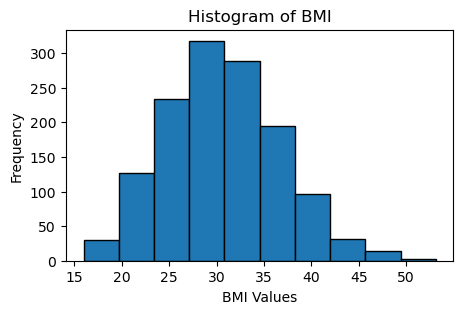

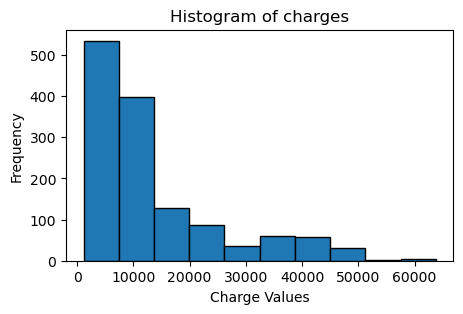

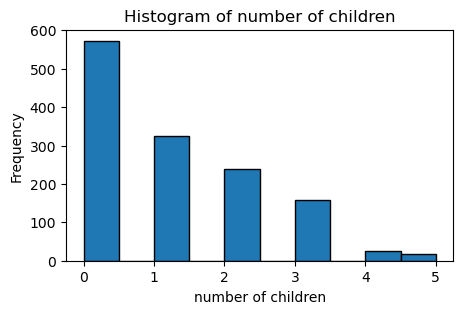



These graphs show us that all three outlier columns exhibit a left-skewed distribution in some way, with BMI showing the most resemblance to a Gausian distribution...
To mitigate the potentially harmful effect that these outliers will have on your linear regression model's generalization accuracy, we must normalize these sets.


In [5]:
#Data Cleaning: Part 4 (A)
#- We need to identify and visualize any outliers in the set to take remedial actions.

#We will be determining the outliers in the dataset using a z-score calculation, which will determine...
#..how many 'standard deviations' a value is away from the mean(Kumar, 2023).


# Compute Z-scores
z_scores = np.abs((cl_data - cl_data.mean()) / cl_data.std()) 
# finds the absolute value of ((the sum of each column entry - the mean of a column) / the standard deviation of a column)
# Z-scores = a set of the z-scores for every entry in the cl_data dataframe (every row and every column)


# Identify outliers (threshold > 3)
outliers = (z_scores > 3).sum() #any outlier is identified when the z-score (standard deviation difference) of an entry is greater than 3
print("Number of outliers per column (original):\n", outliers) 


print("\n")
print("The outlier rows: \n",cl_data[(z_scores > 3).any(axis=1)]) #this line displays exactly which rows contain the outliers inn this dataset


print("\n")
print("These outliers are not unreasonable, and since there are only 1337 rows, Transforming these outliers may be better than deleting the outliers...")
print("But first we must briefly check what the distributons of these outlier columns look like.")
print("\n")


#We will briefly show the distribution of the columns with the identified outliers to show what they look like before transformations

#histogram of BMI distribution
plt.figure(figsize=(5,3))
plt.hist(cl_data['bmi'], bins=10, edgecolor="black")
plt.title(f"Histogram of BMI")
plt.xlabel("BMI Values")
plt.ylabel("Frequency")
plt.show()

#Histogram of charges distribution
plt.figure(figsize=(5,3))
plt.hist(cl_data['charges'], bins=10, edgecolor="black")
plt.title(f"Histogram of charges")
plt.xlabel("Charge Values")
plt.ylabel("Frequency")
plt.show()

#Histogram of Children distribution
plt.figure(figsize=(5,3))
plt.hist(cl_data['children'], bins=10, edgecolor="black")
plt.title(f"Histogram of number of children")
plt.xlabel("number of children")
plt.ylabel("Frequency")
plt.show()

print("\n")
print("These graphs show us that all three outlier columns exhibit a left-skewed distribution in some way, with BMI showing the most resemblance to a Gausian distribution...")
print("To mitigate the potentially harmful effect that these outliers will have on your linear regression model's generalization accuracy, we must normalize these sets.")




Number of outliers per column (transformed):
 age         0
sex         0
bmi         1
children    0
smoker      0
charges     0
dtype: int64




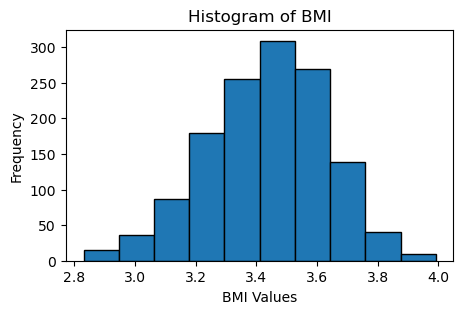

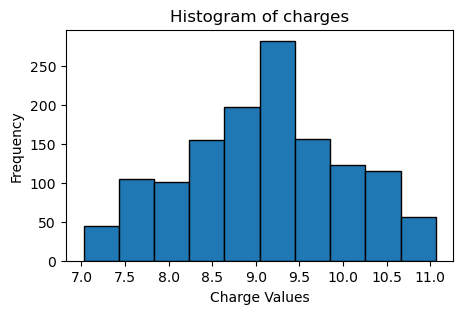

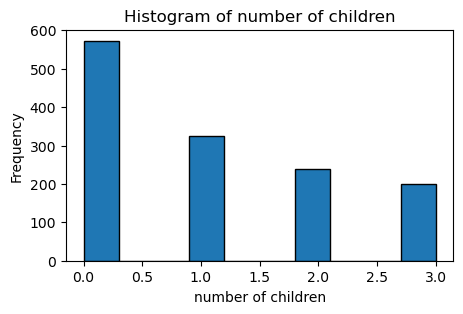



With these transformations put in place, we can see that the distributions of the first two outlier columns have been normalized, and the extreme value difference in the third outlier column is lessened.
This promises to improve the accuracy of our model's generalizations.


Original dataset size: 1337
Transformed dataset size: 1337


In [6]:
#Data Cleaning: Part 4 (B)
#- We need to take remedial actions based on the previously identified outliers.

#copy of cl_data
cl_data2 = cl_data.copy()

#Data transformations

#Log transformations
cl_data2['bmi'] = np.log1p(cl_data2['bmi'])  # the natrural logorithm function ['numpy.log1p(...)'] is used to take a skewed distribution and normalize it to... 
#...a more gausian and usable distribution, this particular line 'normalises' the distribution in the "bmi" column by compressing the outlier 
cl_data2['charges'] = np.log1p(cl_data2['charges'])# We scale the 'charges' values to normalize the distribution, prepare the data for linear regression training...
#... and to imporve visualizations in EDA.

#These lines define the upper and lower limits of acceptable values for outliers.
lower_bound = cl_data2['children'].quantile(0.05) #This line defines the lower bound of acceptable values
upper_bound = cl_data2['children'].quantile(0.95) #This line defines the upper bound of acceptable values
cl_data2['children'] = np.clip(cl_data2['children'], lower_bound, upper_bound)
#This line takes the predefined lower and upper quantiles and 'snips' the outlier values in the "children" column ...
#...to make those values less extreme, to try and improve the generalization of tthe linear regression algorithm.


#calculating the z-scores of the transformed dataset
numeric_cols = cl_data2.select_dtypes(include=['float64', 'int64']).columns  # Exclude categorical columns
z_scores2 = np.abs((cl_data2[numeric_cols] - cl_data2[numeric_cols].mean()) / cl_data2[numeric_cols].std())


#Identifing the outliers of the transformed set
outliers2 = (z_scores2 > 3).sum()

print("Number of outliers per column (transformed):\n", outliers2)  
print("\n")


plt.figure(figsize=(5,3))
plt.hist(cl_data2['bmi'], bins=10, edgecolor="black")
plt.title(f"Histogram of BMI")
plt.xlabel("BMI Values")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(5,3))
plt.hist(cl_data2['charges'], bins=10, edgecolor="black")
plt.title(f"Histogram of charges")
plt.xlabel("Charge Values")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(5,3))
plt.hist(cl_data2['children'], bins=10, edgecolor="black")
plt.title(f"Histogram of number of children")
plt.xlabel("number of children")
plt.ylabel("Frequency")
plt.show()


print("\n")
print("With these transformations put in place, we can see that the distributions of the first two outlier columns have been normalized, and the extreme value difference in the third outlier column is lessened.")
print("This promises to improve the accuracy of our model's generalizations.")
print("\n")

print(f"Original dataset size: {cl_data.shape[0]}") #This line shows what the size of the dataset is pre-tranformations
print(f"Transformed dataset size: {cl_data2.shape[0]}") #This line shows what the size of the dataset is post-transormations
#This is to show that no rows are deleted, which is important in a small dataset such as this




In [7]:
#Data Analysis: Part 1
#The purpose of this section is to identify, summarize and present key insights and stats flounmd within the dataset. 
#For this exercise we will primarily embark in Exploratory Data Analytics (EDA)

print("\nHere is a basic description of several key metrics for each column, post data-cleaning.\n")

#as previously shown, "cl_data2" is the cleaned and normalized set of datapoints due for analysis.
print(f"Description of the insurance dataset: \n{cl_data2.describe()}") #This statement shows the key values of ['item count', mean, standard deviation...
# ... minimum value, lower boundary(Q1, 25%), The median value (Q2, 50%), The upper boundary (Q3, 75%), and Maximum value found in each column.]




Here is a basic description of several key metrics for each column, post data-cleaning.

Description of the insurance dataset: 
               age          sex          bmi     children       smoker  \
count  1337.000000  1337.000000  1337.000000  1337.000000  1337.000000   
mean     39.222139     0.504862     3.436321     1.050112     0.204936   
std      14.044333     0.500163     0.195762     1.097644     0.403806   
min      18.000000     0.000000     2.830858     0.000000     0.000000   
25%      27.000000     0.000000     3.306520     0.000000     0.000000   
50%      39.000000     1.000000     3.446808     1.000000     0.000000   
75%      51.000000     1.000000     3.575151     2.000000     0.000000   
max      64.000000     1.000000     3.991389     3.000000     1.000000   

            region      charges  
count  1337.000000  1337.000000  
mean      1.516081     9.100097  
std       1.105208     0.918551  
min       0.000000     7.023647  
25%       1.000000     8.465341  


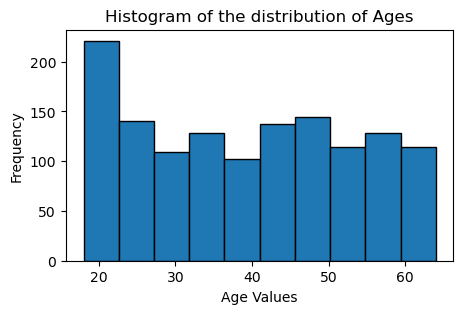

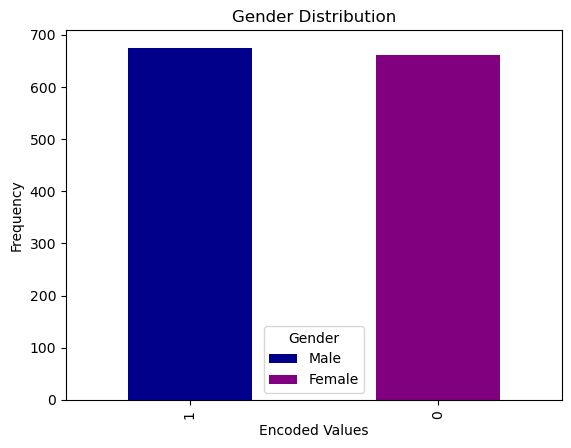

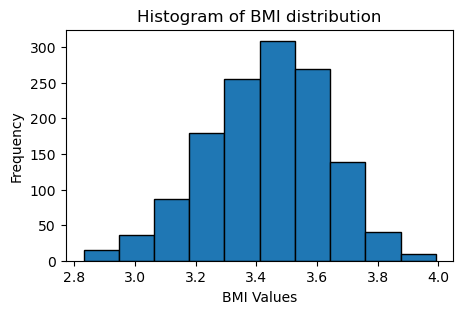

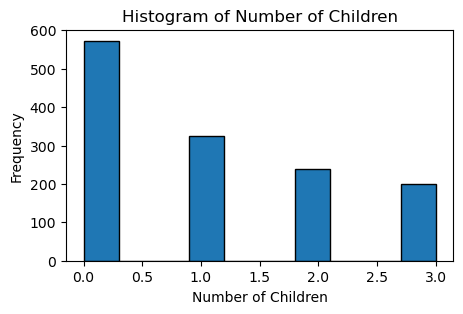

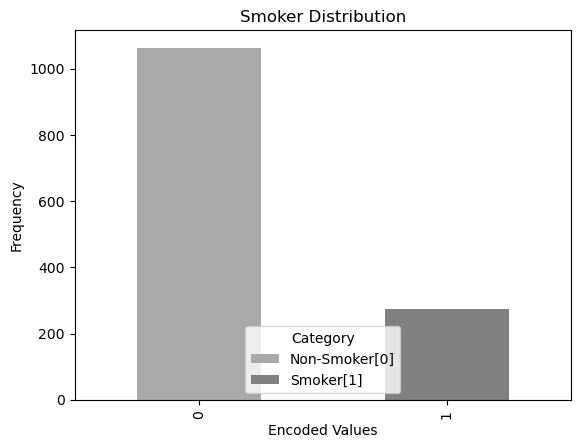

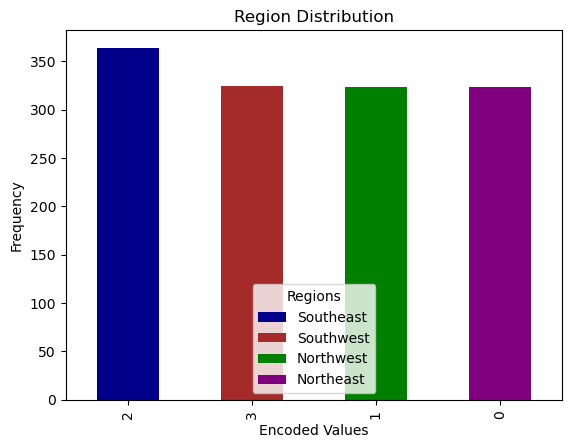

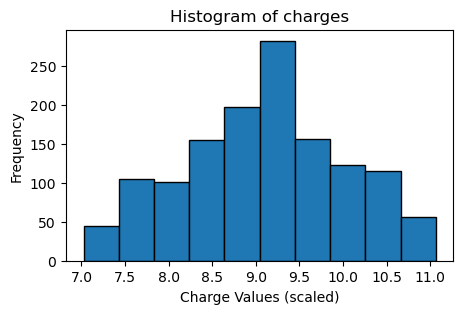

In [8]:
#Data Analysis: Part 2
# Visualization of distributions
#For this section, we first engage in univariate analysis(Codecademy Team, 2025) to understand the distributions of the data 

#Age Histogram
plt.figure(figsize=(5,3))
plt.hist(cl_data2['age'], bins=10, edgecolor="black")
plt.title(f"Histogram of the distribution of Ages")
plt.xlabel("Age Values")
plt.ylabel("Frequency")
plt.show()

#Sex Barchart
cl_data2['sex'].value_counts().plot(kind='bar', color=['darkblue', 'purple']) 
plt.title("Gender Distribution")
plt.xlabel("Encoded Values")
plt.ylabel("Frequency")
legend_elements = [
    Patch(facecolor='darkblue', label='Male'),
    Patch(facecolor='purple', label='Female')
]
plt.legend(handles=legend_elements, title='Gender', loc='lower center')
plt.show()

#BMI Histogram
plt.figure(figsize=(5,3))
plt.hist(cl_data2['bmi'], bins=10, edgecolor="black")
plt.title(f"Histogram of BMI distribution")
plt.xlabel("BMI Values")
plt.ylabel("Frequency")
plt.show()

#Children Histogram
plt.figure(figsize=(5,3))
plt.hist(cl_data2['children'], bins=10, edgecolor="black")
plt.title(f"Histogram of Number of Children")
plt.xlabel("Number of Children")
plt.ylabel("Frequency")
plt.show()

#Smoker Barchart
cl_data2['smoker'].value_counts().plot(kind='bar', color=['darkgrey', 'grey']) 
plt.title("Smoker Distribution")
plt.xlabel("Encoded Values")
plt.ylabel("Frequency")
legend_elements = [
    Patch(facecolor='darkgrey', label='Non-Smoker[0]'), #Note: for whatever reason, 'grey' is darker than 'dark grey'
    Patch(facecolor='grey', label='Smoker[1]')
]
plt.legend(handles=legend_elements, title='Category', loc='lower center')
plt.show()

#Regions Bar chart
cl_data2['region'].value_counts().plot(kind='bar', color=['darkblue', 'brown', 'green', 'purple']) 
plt.title("Region Distribution")
plt.xlabel("Encoded Values")
plt.ylabel("Frequency")
legend_elements = [
    Patch(facecolor='darkblue', label='Southeast'),
    Patch(facecolor='brown', label='Southwest'),
    Patch(facecolor='green', label='Northwest'),
    Patch(facecolor='purple', label='Northeast')
]
plt.legend(handles=legend_elements, title='Regions', loc='lower center')
plt.show()

#Charges Histogram
plt.figure(figsize=(5,3))
plt.hist(cl_data2['charges'], bins=10, edgecolor="black")
plt.title(f"Histogram of charges")
plt.xlabel("Charge Values (scaled)")
plt.ylabel("Frequency")
plt.show()




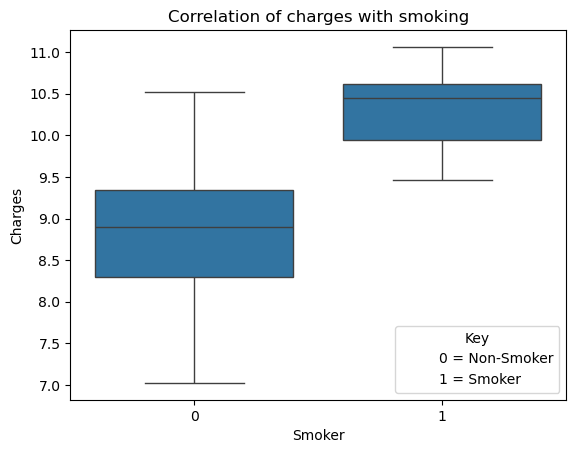

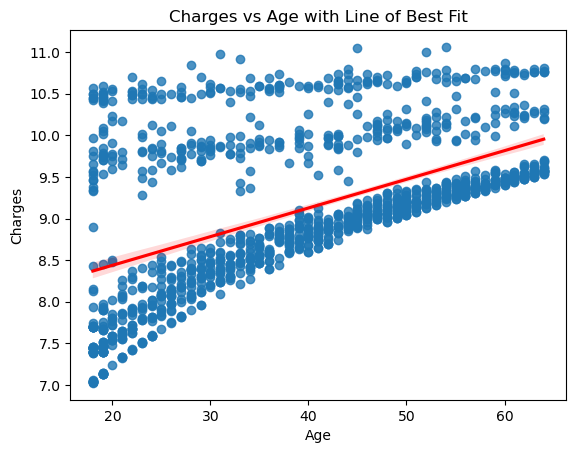

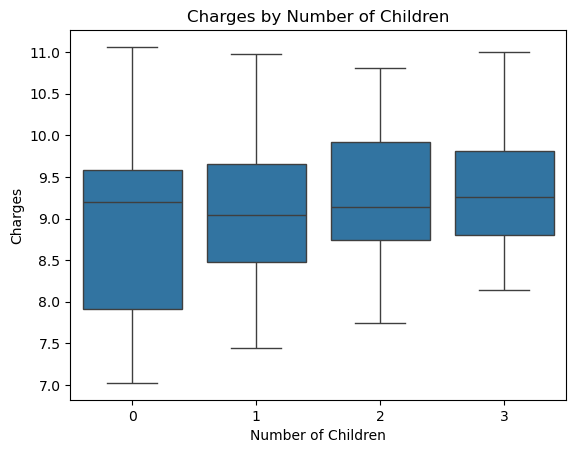

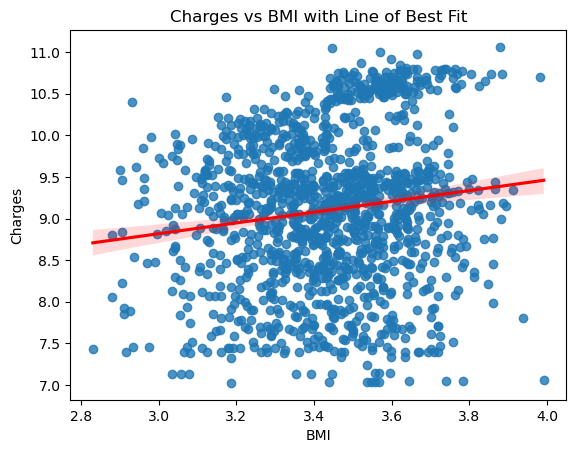

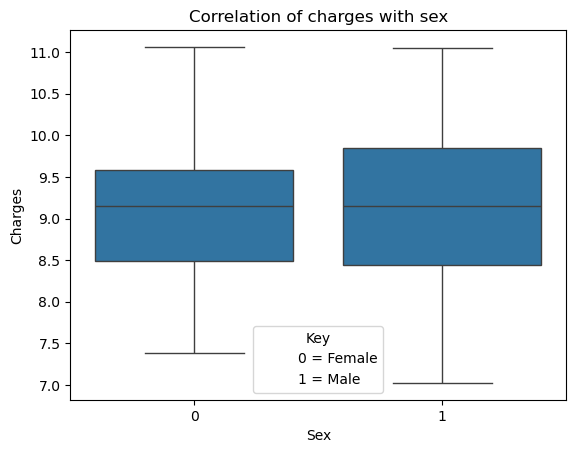

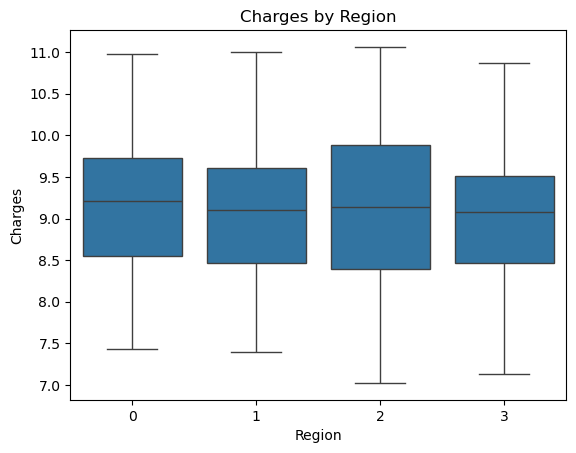

In [9]:
#Data Analysis: Part 3 A
#Determine correlations:
#Our goal in this section is to identify and visualize the relationships between the independent variables, and the dependent variables,
#in the case of the insurance example, the dependent variable, or the variable we are seeking to predict, is the insurance charges.
#So we must determine what the relationships and correlations are between the independent variables ('Bmi','Region','Age', etc.)


#Smoker: Continuous vs Binary
sns.boxplot(x='smoker', y='charges', data = cl_data2)
plt.title("Correlation of charges with smoking")
legend_elements = [
    Patch(facecolor='White', label='0 = Non-Smoker'),
    Patch(facecolor='White', label='1 = Smoker'),
]
plt.legend(handles=legend_elements, title='Key', loc='lower right')
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.show()


#Age: Continuous vs Discrete values, 
#The scatter plot representing the Correlation of Age to charges, accompanied by a regression line
sns.regplot(x='age', y='charges', data=cl_data2, line_kws={"color": "red"})

plt.title('Charges vs Age with Line of Best Fit')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()


#Children: Continuous vs Discrete
sns.boxplot(x='children', y='charges', data=cl_data2)
plt.title('Charges by Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Charges')
plt.show()

#BMI: Continuous vs Continuous
sns.regplot(x='bmi', y='charges', data=cl_data2, line_kws={"color": "red"})
plt.title('Charges vs BMI with Line of Best Fit')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

#Sex: Binary vs Continous
sns.boxplot(x='sex', y='charges', data = cl_data2)
plt.title("Correlation of charges with sex")
legend_elements = [
    Patch(facecolor='White', label='0 = Female'),
    Patch(facecolor='White', label='1 = Male'),
]
plt.legend(handles=legend_elements, title='Key', loc='lower center')
plt.xlabel('Sex')
plt.ylabel('Charges')
plt.show()

#Region
#Children: Continuous vs Discrete
sns.boxplot(x='region', y='charges', data=cl_data2)
plt.title('Charges by Region')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.show()

#[A notable finding here is that the Age vs Charges chart seems to display 3 horizontal bands, all showing an upward trend in growth. This could...
#.. potentially be indicating that The charges applied to certain ages may also be affected by another feature] 


In [10]:
#Data Analysis: Part 3 B
#In order to test my suspicions of Multicollinearity in the 'Age' distribution, we will use VI (Variance Inflation Factor) (Singh, 2024) ...
#..to assess the level of intercorrelation 'Age' has to the other independent variables.

#Selecting only the independent variables of the set (excluding 'charges')
xVif = cl_data2[['age', 'bmi', 'children', 'sex', 'smoker', 'region']]  

#Add a constant column for intercept
xVif = add_constant(xVif)

#Computing VIF for each feature
vif_dataf = pd.DataFrame()
vif_dataf['Feature'] = xVif.columns
vif_dataf['VIF'] = [variance_inflation_factor(xVif.values, i_feature) for i_feature in range(xVif.shape[1])]


#Displaying the VIF score for 'age'
print("VIF score for Age:")
print(vif_dataf[vif_dataf['Feature'] == 'age'])

print("")

#Displaying the VIF scores for the other features
print("VIF scores for the other features:")
print(vif_dataf[vif_dataf['Feature'] == 'bmi'],"\n")
print(vif_dataf[vif_dataf['Feature'] == 'children'],"\n")
print(vif_dataf[vif_dataf['Feature'] == 'sex'],"\n")
print(vif_dataf[vif_dataf['Feature'] == 'smoker'],"\n")
print(vif_dataf[vif_dataf['Feature'] == 'region'],"\n")



#Interpretation of VIF is generally as follows, if 'VIF = 1' then there is absolutely no multicollinearity...
#if '1<VIF<5' then the multicollinearily is low to moderate, which is acceptable for linear regression,
#if 'VIF>5' then the multicollinearity is high, meaning remedial action must be taken for those features before applying the rergression model (Singh, 2024)

print("The VIF score of '1.017916' for age indicates that, while there is some multicollinearity for this feature, the extent of which is very low, and thus we can still use it for the linear regression models without further intervention.")


VIF score for Age:
  Feature       VIF
1     age  1.017916

VIF scores for the other features:
  Feature       VIF
2     bmi  1.042808 

    Feature       VIF
3  children  1.003557 

  Feature       VIF
4     sex  1.008813 

  Feature       VIF
5  smoker  1.006937 

  Feature       VIF
6  region  1.026288 

The VIF score of '1.017916' for age indicates that, while there is some multicollinearity for this feature, the extent of which is very low, and thus we can still use it for the linear regression models without further intervention.


In [11]:
#Data Analysis: Part 3 C
#Calulating correlation scores.

# Spearman Correlation for ordinal/discrete values
age_corr, _ = spearmanr(cl_data2['age'], cl_data2['charges'])
children_corr, _ = spearmanr(cl_data2['children'], cl_data2['charges'])

# Pearson Correlation for continuous values
bmi_corr, _ = pearsonr(cl_data2['bmi'], cl_data2['charges'])

# Point-Biserial Correlation for binary variables
smoker_corr, smoker_p = pointbiserialr(cl_data2['smoker'], cl_data2['charges'])
sex_corr, sex_p = pointbiserialr(cl_data2['sex'], cl_data2['charges'])

# ANOVA for categorical variables
groups = [cl_data2[cl_data2['region'] == val]['charges'] for val in cl_data2['region'].unique()]
f_stat, p_val = f_oneway(*groups)

# Printing results
print("Correlation scores for each of the independent variables:")
print("")
print(f"Smoker - Point-Biserial Correlation: r = {smoker_corr:.3f}, p = {smoker_p:.3f}")
print("[A strong r-value of '0.666' and a p-value < 0.05 suggest a significant, strong, positive correlation. Being a smoker increases the likelihood of higher charges.]")

print("")

print(f"Age - Spearman Correlation: r = {age_corr:.3f}")
print("[For 'age', the r-value of '0.534' indicates a moderate, positive correlation which suggests that charges tend to increase with age.]")

print("")

print(f"Children - Spearman Correlation: r = {children_corr:.3f}")
print("[For 'children', the weak positive r-value of '0.134' suggests a minimal correlation with charges. This implies number of children has little...")
print("..but notable impact on charges.]")

print("")

print(f"BMI - Pearson Correlation: r = {bmi_corr:.3f}")
print("[For 'bmi', a low r-value of '0.138' suggests a weak positive correlation with charges, indicating it likely little but notable predictive power.]")

print("")

print(f"Sex - Point-Biserial Correlation: r = {sex_corr:.3f}, p = {sex_p:.3f}")
print("[An extremely low r-value and a high p-value indicates no significant correlation between sex and charges.]")

print("")

print(f"Region - ANOVA: F = {f_stat:.3f}, p = {p_val:.3f}")
print("[For region, the p-value > 0.05, which means the f-value is not significant and the variations of charges in relation to region are likely...")
print("... caused by chance, while...")
print("...the F-value is 1.369, meaning the 'region' column does not have a stong impact on or correlation with the 'charges' column anyway.]")
#Note that: in regards to 'F-values', [F<1 indicates no likely relationship], [5<F<10 indicates that there is likely a moderate correlation],
#... [F>10 indicates a very strong correlation between an independent variable and a target variable] 


#ANOVA correlation is used in the case of Region vs Charges
groups = [cl_data2[cl_data2['region'] == val]['charges'] for val in cl_data['region'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"Region - ANOVA: F = {f_stat:.3f}, p = {p_val:.3f}")


Correlation scores for each of the independent variables:

Smoker - Point-Biserial Correlation: r = 0.666, p = 0.000
[A strong r-value of '0.666' and a p-value < 0.05 suggest a significant, strong, positive correlation. Being a smoker increases the likelihood of higher charges.]

Age - Spearman Correlation: r = 0.534
[For 'age', the r-value of '0.534' indicates a moderate, positive correlation which suggests that charges tend to increase with age.]

Children - Spearman Correlation: r = 0.134
[For 'children', the weak positive r-value of '0.134' suggests a minimal correlation with charges. This implies number of children has little...
..impact on charges.]

BMI - Pearson Correlation: r = 0.138
[For 'bmi', a low r-value of '0.138' suggests a weak positive correlation with charges, indicating it likely little but notable predictive power.]

Sex - Point-Biserial Correlation: r = 0.007, p = 0.798
[An extremely low r-value and a high p-value indicates no significant correlation between sex a

In [43]:
#Model Training: Part 1
#After cleaning and analysis, the dataset is now actually applied to fit a linear regression model 


#Separating the features and target
x = cl_data2.drop(columns=['charges', 'region', 'sex']) #the columns with low statistical significance and the weakest correlations to 'charges' are dropped...
#.. as well as the dependent variable itself
y = cl_data2['charges'] #the dependent variable is segmented into its own subset


#Setting up the Training-Testing split, 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#'test-size=0.2' sets the test data to be 20% of the total set
#'random_state=42' sets how the random number generator, responsible for randomly selecting which values will go into training and testing sets. will behave

#Training Linear Regression (Basic Multiple Linear Regression)
linModel = LinearRegression() #defining the Linear regression model
linModel.fit(x_train, y_train) #fitting the segmenred training data
y_pred_linMod = linModel.predict(x_test)

#I decided that, to further test the performance of the Linear regression model, i would also train up a ...
#..Lasso regression model (A different type of linear model that regularizes the data more) in order to compare the results and ...
#.. key performance metrics (R^2, RMSE, Actual vs Predicted values)

#Training Lasso Regression with cross-validation to find optimal alpha
lassoModel = LassoCV(cv=5, random_state=42)
lassoModel.fit(x_train, y_train)
y_pred_lassoMod = lassoModel.predict(x_test)


---- Linear Regression ----
R^2 Score: 0.8202
RMSE: 0.4084

---- Lasso Regression ----
Optimal Alpha: 0.0066
R^2 Score: 0.8175
RMSE: 0.4115

Linear Coefficients:
age         0.034050
children    0.107936
bmi         0.356455
smoker      1.521101
dtype: float64

Lasso Coefficients:
age         0.034327
children    0.102815
bmi         0.177728
smoker      1.478929
dtype: float64


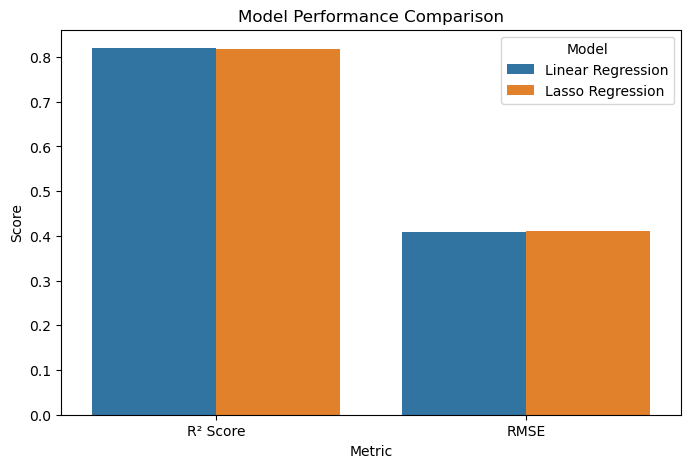

In [45]:
#Model Evaluation: Part 1
#for evaluation, we need to calculate the 'R squared' value and the RMSE value

#the R^2 value, or "Coefficient of determination" (LibreTexts, 2025), is a statistical measure that embodies how well a regression model predicts ...
#.. the variance observed in dependent variables based on independent variables(LibreTexts, 2025). This is useful for determining how well a...
#.. model captures the trends in a dataset.

#The 'Root Mean Square Error' (RMSE) metric is used to measure the distance between predicted and actual values in the context of ...
#..regression modelling(LibreTexts, 2025). This is also very useful for measuring the accuracy of a regression model.

# Evaluate both models for comparrison
print("---- Linear Regression ----")
print(f"R^2 Score: {r2_score(y_test, y_pred_linMod):.4f}") #This line determines the R^2 value for the linear regression model, comparing the test val's 
#..to the predicted values
print(f"RMSE: {root_mean_squared_error(y_test, y_pred_linMod):.4f}") #This Line determines the average RMSE value for the linear regression model...
#.. determining the difference between every predicted and actual value in the model
print()


print("---- Lasso Regression ----")
print(f"Optimal Alpha: {lassoModel.alpha_:.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred_lassoMod):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred_lassoMod):.4f}")
print()


# Inspect Lasso coefficients
linear_coeffs = pd.Series(linModel.coef_, index=x.columns)
lasso_coeffs = pd.Series(lassoModel.coef_, index=x.columns)
print("Linear Coefficients:")
print(linear_coeffs.sort_values())
print("")
print("Lasso Coefficients:")
print(lasso_coeffs.sort_values())


# Metrics
metrics = ['R² Score', 'RMSE']
linear_scores = [r2_score(y_test, y_pred_linMod), root_mean_squared_error(y_test, y_pred_linMod)]
lasso_scores = [r2_score(y_test, y_pred_lassoMod), root_mean_squared_error(y_test, y_pred_lassoMod)]

# Combine into a dataframe for plotting
import pandas as pd
dfCombo = pd.DataFrame({
    'Metric': metrics * 2,
    'Value': linear_scores + lasso_scores,
    'Model': ['Linear Regression'] * 2 + ['Lasso Regression'] * 2
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=dfCombo, x='Metric', y='Value', hue='Model')
plt.title("Model Performance Comparison")
plt.ylabel("Score")plt.show()



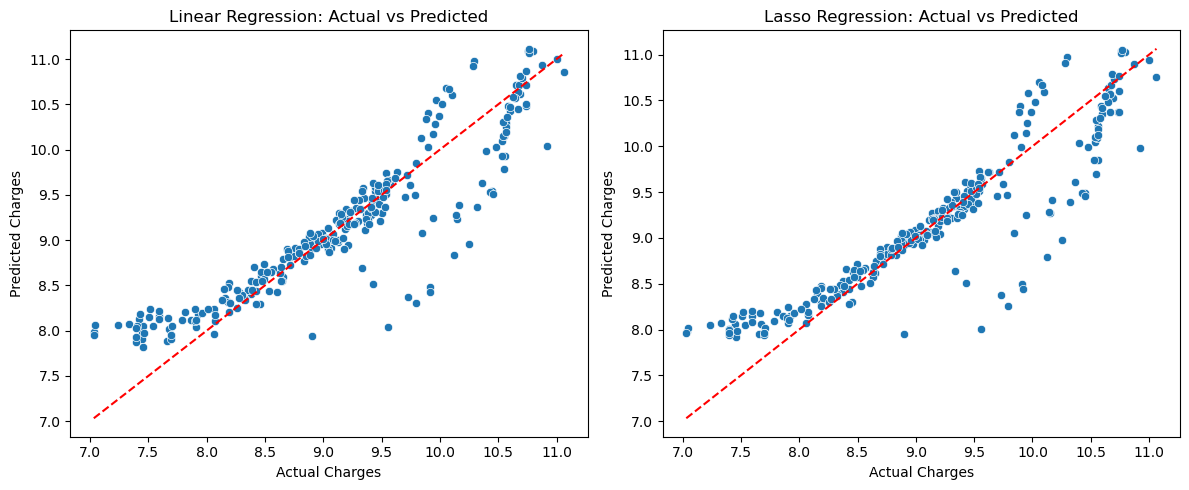

In [47]:
#Model Evaluation: Part 2
#We need to evaluate how the predicted values compare to the actual values for the test data
#We do this by representing the Predicted vs actiual Relationships in a scatteplot graph

plt.figure(figsize=(12, 5))

# Linear Regression
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_linMod)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')

# Lasso Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_lassoMod)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Lasso Regression: Actual vs Predicted')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')

plt.tight_layout()
plt.show()




#References 

Kumar, A., 2023. Z-score or Z-statistics: Concepts, Formula & Examples. [online] vitalflux.com. Available at: <https://vitalflux.com/z-score-z-statistics-concepts-formula-examples/> [Accessed 25 April 2025].

Codecademy Team, 2025. Exploratory Data Analysis with Data Visualization. [online] codecademy.com. Available at: <https://www.codecademy.com/article/eda-data-visualization> [Accessed 25 April 2025].

Singh, V., 2024. Variance Inflation Factor (VIF): Addressing Multicollinearity in Regression Analysis. [online] datacamp.com. Available at: <https://www.datacamp.com/tutorial/variance-inflation-factor> [Accessed 25 April 2025].

statisticshowto.com, 2016. Point-Biserial Correlation & Biserial Correlation: Definition, Examples. [online] statisticshowto.com. Available at: <https://www.statisticshowto.com/point-biserial-correlation/> [Accessed 25 April 2025].

statisticshowto.com, 2021. Spearman Rank Correlation (Spearman’s Rho): Definition and How to Calculate it. [online] statisticshowto.com. Available at: <https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/spearman-rank-correlation-definition-calculate/> [Accessed 25 April 2025].

LibreTexts, 2025. 4.3: Correlation and Linear Regression Analysis. eng.libretexts.org.

LibreTexts, 2025. 10.2: Validating Your Model. [online] eng.libretexts.org. Available at: <https://eng.libretexts.org/Bookshelves/Data_Science/Principles_of_Data_Science_(OpenStax)/10%3A_Reporting_Results/10.02%3A_Validating_Your_Model> [Accessed 25 April 2025].

